In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rc
font={'size':18}
rc('font',**font)
from matplotlib.colors import PowerNorm, LightSource
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Rectangle, ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely.geometry as sgeom
from pyproj import Proj
import netCDF4 as nc


### Plotting the map in Figure 2

This map relies on the `geopandas` package. Install instructions can be found at: https://geopandas.org/en/stable/getting_started/install.html . We highly recommend you install this as a separate anaconda environment (see "creating a new environment" in link above) as it often has incompatibilities with other packages. Additionlly you will need the `shapely`, `matplotlib` and `pandas` `numpy` packages, most of which ought to be installed with geopandas. Additionally, you will need to install the `netCDF4` and `pyproj` packages.

### Datasets used in the creation of this map

The map relies on three datasets:
1. [Geological map of the state of Hawaii (Sherrod 2007)](https://pubs.usgs.gov/of/2007/1089/)
2. [Hawaii Coastline GIS Dataset](https://geoportal.hawaii.gov/datasets/coastline/explore?location=20.514624%2C-157.491300%2C7.33)
3. USGS 10-m Digital Elevation Model (DEM): Hawaii. [Big Island](https://www.pacioos.hawaii.edu/metadata/usgs_dem_10m_bigisland.html), [Maui](https://www.pacioos.hawaii.edu/metadata/usgs_dem_10m_maui.html), [Molokai](https://www.pacioos.hawaii.edu/metadata/usgs_dem_10m_molokai.html), [Oahu](https://www.pacioos.hawaii.edu/metadata/usgs_dem_10m_oahu.html). These data were transformed to UTM4 coordinates using the `gdal` package.


In [2]:
###Functions to help with map plotting
def plot_dem_image(filename,ax,minx,maxx,miny,maxy):
    """
    Plots a hillshading plot using DEM topography.
    
    Inputs
    ------
    filename: str
    Path of file of DEM plot
    
    ax: matplotlib axis
    Axis to plot the DEM plot on
    
    minx: float
    minimum x extent of the DEM map
    
    maxx: float
    maximum x extent of the DEM map
    
    miny: float
    minimum y extent of the DEM map
    
    maxy: float
    maximum y extent of the DEM map

    """
    
    #Load in "Warped" DEM Image (UTM4)
    warped=nc.Dataset(filename)
    warped['Band1'].__array__()
    
    
    x=warped['x'].__array__()
    y=warped['y'].__array__()
    
    elev=warped['Band1'].__array__()
    xx,yy=np.meshgrid(x,y)
    elev[elev==0]=np.nan
    elev=elev[(xx>=minx)&(xx<=maxx)&(yy>=miny)&(yy<=maxy)]
    x=x[(x>=minx)&(x<=maxx)]
    y=y[(y>=miny)&(y<=maxy)]
    
    
    elev=elev.reshape((len(y),len(x)))
    ls = LightSource(azdeg=235, altdeg=45)
    cmap=plt.cm.gray.copy()
    cmap.set_bad('lightblue',1.)

    ax.imshow(ls.hillshade(elev, dx=x, dy=y,vert_exag=10), cmap=cmap,origin='lower',extent=[np.amin(x),np.amax(x),np.amin(y),np.amax(y)])
    
def plot_grids(ax,s,lw,zorder,set_ticks=False):
    """
    Plots the lat/lon grid for a utm axis
    
    Inputs
    ------
    ax: matplotlib axis
    axis to add grid to
    
    s: int
    Number of grid lines per degree of latitude/longitude
    e.g. 4 will plot a grid line every .25 degrees.
    
    lw: float
    Width of lines to plot.
    
    set_ticks: bool
    If True, sets x and y ticks and ticklabels to match 
    the gridlines
    
    Returns
    -------
    None
    """
    #Set up UTM4 projection
    UTM4Proj=Proj(UTM4)
    
    #Get limits of grid
    xlim=ax.get_xlim()
    ylim=ax.get_ylim()
    xs,ys=np.meshgrid(xlim,ylim)
    
    #Get lat/lon of limits
    latlons=UTM4Proj(xs,ys,inverse=True)
    minlon,maxlon=np.amin(latlons[0]),np.amax(latlons[0])
    minlat,maxlat=np.amin(latlons[1]),np.amax(latlons[1])
    
    #Create x and y points for lines
    xticks=np.arange(np.ceil((minlon-1/s)*s)/s,np.floor(maxlon*s)/s+1/s+1e-3,1/s)
    yticks=np.arange(np.ceil((minlat-1/s)*s)/s,np.floor(maxlat*s)/s+1/s+1e-3,1/s)
    xticks=np.round(xticks,3)
    yticks=np.round(yticks,3)

    #Create points for gridlines
    lines=np.array(np.meshgrid(xticks,yticks))
    latlines=[]
    
    #Create shapely geometry for lines of latitude
    for i in range(lines.shape[1]):
        linepts=lines[:,i,:].T
        line=sgeom.LineString(linepts)
        latlines.append(line)
        
        
    #Convert back to UTM4 and plot
    latlines=gpd.GeoSeries(latlines,crs=WGS84).to_crs(UTM4)
    latlines.plot(ax=ax,color='w',linestyle='--',linewidth=1,zorder=3,alpha=0.5)
    
    #Do the same for lines of longitude
    lonlines=[]
    for i in range(lines.shape[2]):
        linepts=lines[:,:,i].T
        line=sgeom.LineString(linepts)
        lonlines.append(line)

    lonlines=gpd.GeoSeries(lonlines,crs=WGS84).to_crs(UTM4)
    lonlines.plot(ax=ax,color='w',linestyle='--',linewidth=lw,zorder=zorder,alpha=0.5)
    
    
    #Reset x,y limits to before plotting grid lines
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    
    
    #Create x and y tick labels if set_ticks is set to True
    
    if set_ticks:
        yticks_new=yticks[1:-1]
        x_loc=np.full(len(yticks_new),minlon)
        ytick_locs=UTM4Proj(x_loc,yticks_new)[1]
        ax.set_yticks(ytick_locs,yticks_new)
        xticks_new=xticks[1:-1]
        y_loc=np.full(len(xticks_new),maxlat)
        xtick_locs=UTM4Proj(xticks_new,y_loc)[0]
        ax.set_xticks(xtick_locs,xticks_new)
        ax.xaxis.tick_top()
        
    
    
def plot_volcano_map(islandstr,volcanostr,ax,filename,rescale=True,scale=1e-3):
    """
    Plots inset maps of an island and its boundaries
    
    Inputs
    ------
    islandstr: str
    String of island location (e.g. MU for Maui, HW for Hawaii etc).
    
    volcanostr: str
    String of volcano in geological map, look at the "flows" shapefile
    for more info.
    
    ax: matplotlib axis
    Name of axis to plot the map on.
    
    filename: str
    Path of file to grab digital elevation map for hillshading plot.
    
    rescale: bool
    Whether to rescale the map to just the scale of the data
    
    scale: float
    Scales the extent of the map by multiplying northing and easting values
    by 1+/- this amount.
    
    Returns
    -------
    None
    """
    #Get locations of site from that island
    sites_island=sites_passing[sites_passing['site'].str.contains(islandstr)]
    island_locs=gpd.GeoSeries(gpd.points_from_xy(sites_island.lon, sites_island.lat),crs=WGS84).to_crs(UTM4)
    
    #Set initial extent of map
    extent=flows[(flows['VOLCANO'].isin(volcanostr))].unary_union.bounds
    minx,maxx=extent[0]*(1-scale),extent[2]*(1+scale)
    miny,maxy=extent[1]*(1-scale),extent[3]*(1+scale)
    
    #If rescale true, rescale to data extent.
    if rescale==True:
        island_locs=island_locs.cx[minx:maxx,miny:maxy]
        extent=island_locs.unary_union.bounds
        minx,maxx=extent[0]*(1-scale),extent[2]*(1+scale)
        miny,maxy=extent[1]*(1-scale),extent[3]*(1+scale)
        
    
    #Plot dem hillshading plot
    plot_dem_image(filename,ax,minx,maxx,miny,maxy)
    
    #Make colormap for Hawaiian islands
    norm=PowerNorm(gamma=0.4,vmin=1e-4,vmax=4) #Non linear color scale
    
    #Filter and plot only flows and dikes from the volcano of interest
    flows[(flows.VOLCANO.isin(volcanostr))].plot(ax=ax,column='Ages',cmap='inferno',norm=norm,edgecolor='k',alpha=0.8)
    dikes[dikes.VOLCANO.isin(volcanostr)].plot(ax=ax,color='r')
    
    #Plot sampling localities as cyan stars
    island_locs.plot(ax=ax,color='c',marker='*',edgecolor='k',markersize=300,zorder=10)

    #Set xlim, ylim back to extent of volcano if they got changed.
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    
    #Turn off tick labels
    ax.set_xticks([])
    ax.set_yticks([])

    #Set facecolor of plot
    ax.set_facecolor(color='lightblue')
    
def plot_patch(fromax,toax,xya):
    """
    Plots boxes and lines linking inset patches to axis
    
    Inputs
    ------
    fromax: matplotlib axis
    inset axis
    
    toax: matplotlib axis
    main map axis
    
    xya: list of floats
    x and y coordinates on inset axis. [0,0] is bottom
    left, [1,1] is top right etc. Will join to opposite 
    side on main map.
    
    Returns
    -------
    None
    """
    #Get inset axis limits
    xlim=fromax.get_xlim()
    ylim=fromax.get_ylim()
    
    #Parameters for plotting a box on the main map
    xy=np.array([xlim[0],ylim[0]])
    width=np.diff(xlim)[0]
    height=np.diff(ylim)[0]

    #Add rectangle on the main map
    toax.add_patch(Rectangle(xy,width,height,edgecolor='k',facecolor='None',zorder=4))
    
    #Line endpoint on the main map
    xyb=[(1-xya[0])*(xlim[1]-xlim[0])+xlim[0],(1-xya[1])*(ylim[1]-ylim[0])+ylim[0]]
    
    #Add connectng line between two axes
    fromax.add_patch(ConnectionPatch(xya,xyb,coordsA='axes fraction',coordsB='data',axesA=fromax,axesB=toax,zorder=4))

In [3]:
#Coordinate systems for geopandas
UTM4='+proj=utm +zone=4 +ellps=GRS80 +datum=NAD83 +units=m +no_defs'
WGS84='+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

#Import flows, dikes and coastline files for map
hawaii=gpd.read_file('Coastline.shp',crs=WGS84).to_crs(UTM4)
flows=gpd.read_file('Flows.shp',crs=UTM4)
dikes=gpd.read_file('Dikes.shp',crs=UTM4)

In [4]:
#Get rid of alluvium and water, we just care about extrusive rocks here.
flows=flows[(flows.VOLC_STAGE!='alluv')&(flows.VOLC_STAGE!='water')]


#Fix ages to be on Ma scale
flows['MULTIPLIER']=1
flows.loc[flows.AGE_RANGE.str.contains('Ma'),'MULTIPLIER']=1
flows.loc[flows.AGE_RANGE.str.contains('yr'),'MULTIPLIER']=1e-6
flows['Ages']=flows.AGE_RANGE.str.replace(',','').str.findall('\d*\.?\d+')
Ages=pd.DataFrame(flows['Ages'].values.tolist()).astype(float).mean(axis=1)
Ages.index=flows.index
flows['Ages']=Ages
flows['Ages']*=flows['MULTIPLIER']
flows.loc[flows['AGE_RANGE'].str.contains('A.D.'),'Ages']=(2022-flows[flows['AGE_RANGE'].str.contains('A.D.')]['Ages'])/1e6

In [5]:
#Import Sites, find sites which pass criteria.
sites=pd.read_csv('sites.txt',sep='\t',skiprows=1)
CCRIT_abs_pass=(sites.int_abs_sigma<=4e-6)
CCRIT_perc_pass=(sites.int_abs_sigma/sites.int_abs<=0.1)
BiCEP_abs_pass=(sites.int_abs_max-sites.int_abs_min<=1.6e-5)
BiCEP_perc_pass=((sites.int_abs_max-sites.int_abs_min)/sites.int_abs<=0.4)
passing=CCRIT_abs_pass|CCRIT_perc_pass|BiCEP_abs_pass|BiCEP_perc_pass
sites_passing=sites[passing]

/home/brendan/anaconda3/envs/geopandas/lib/python3.8/site-packages/geopandas/plotting.py:678: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


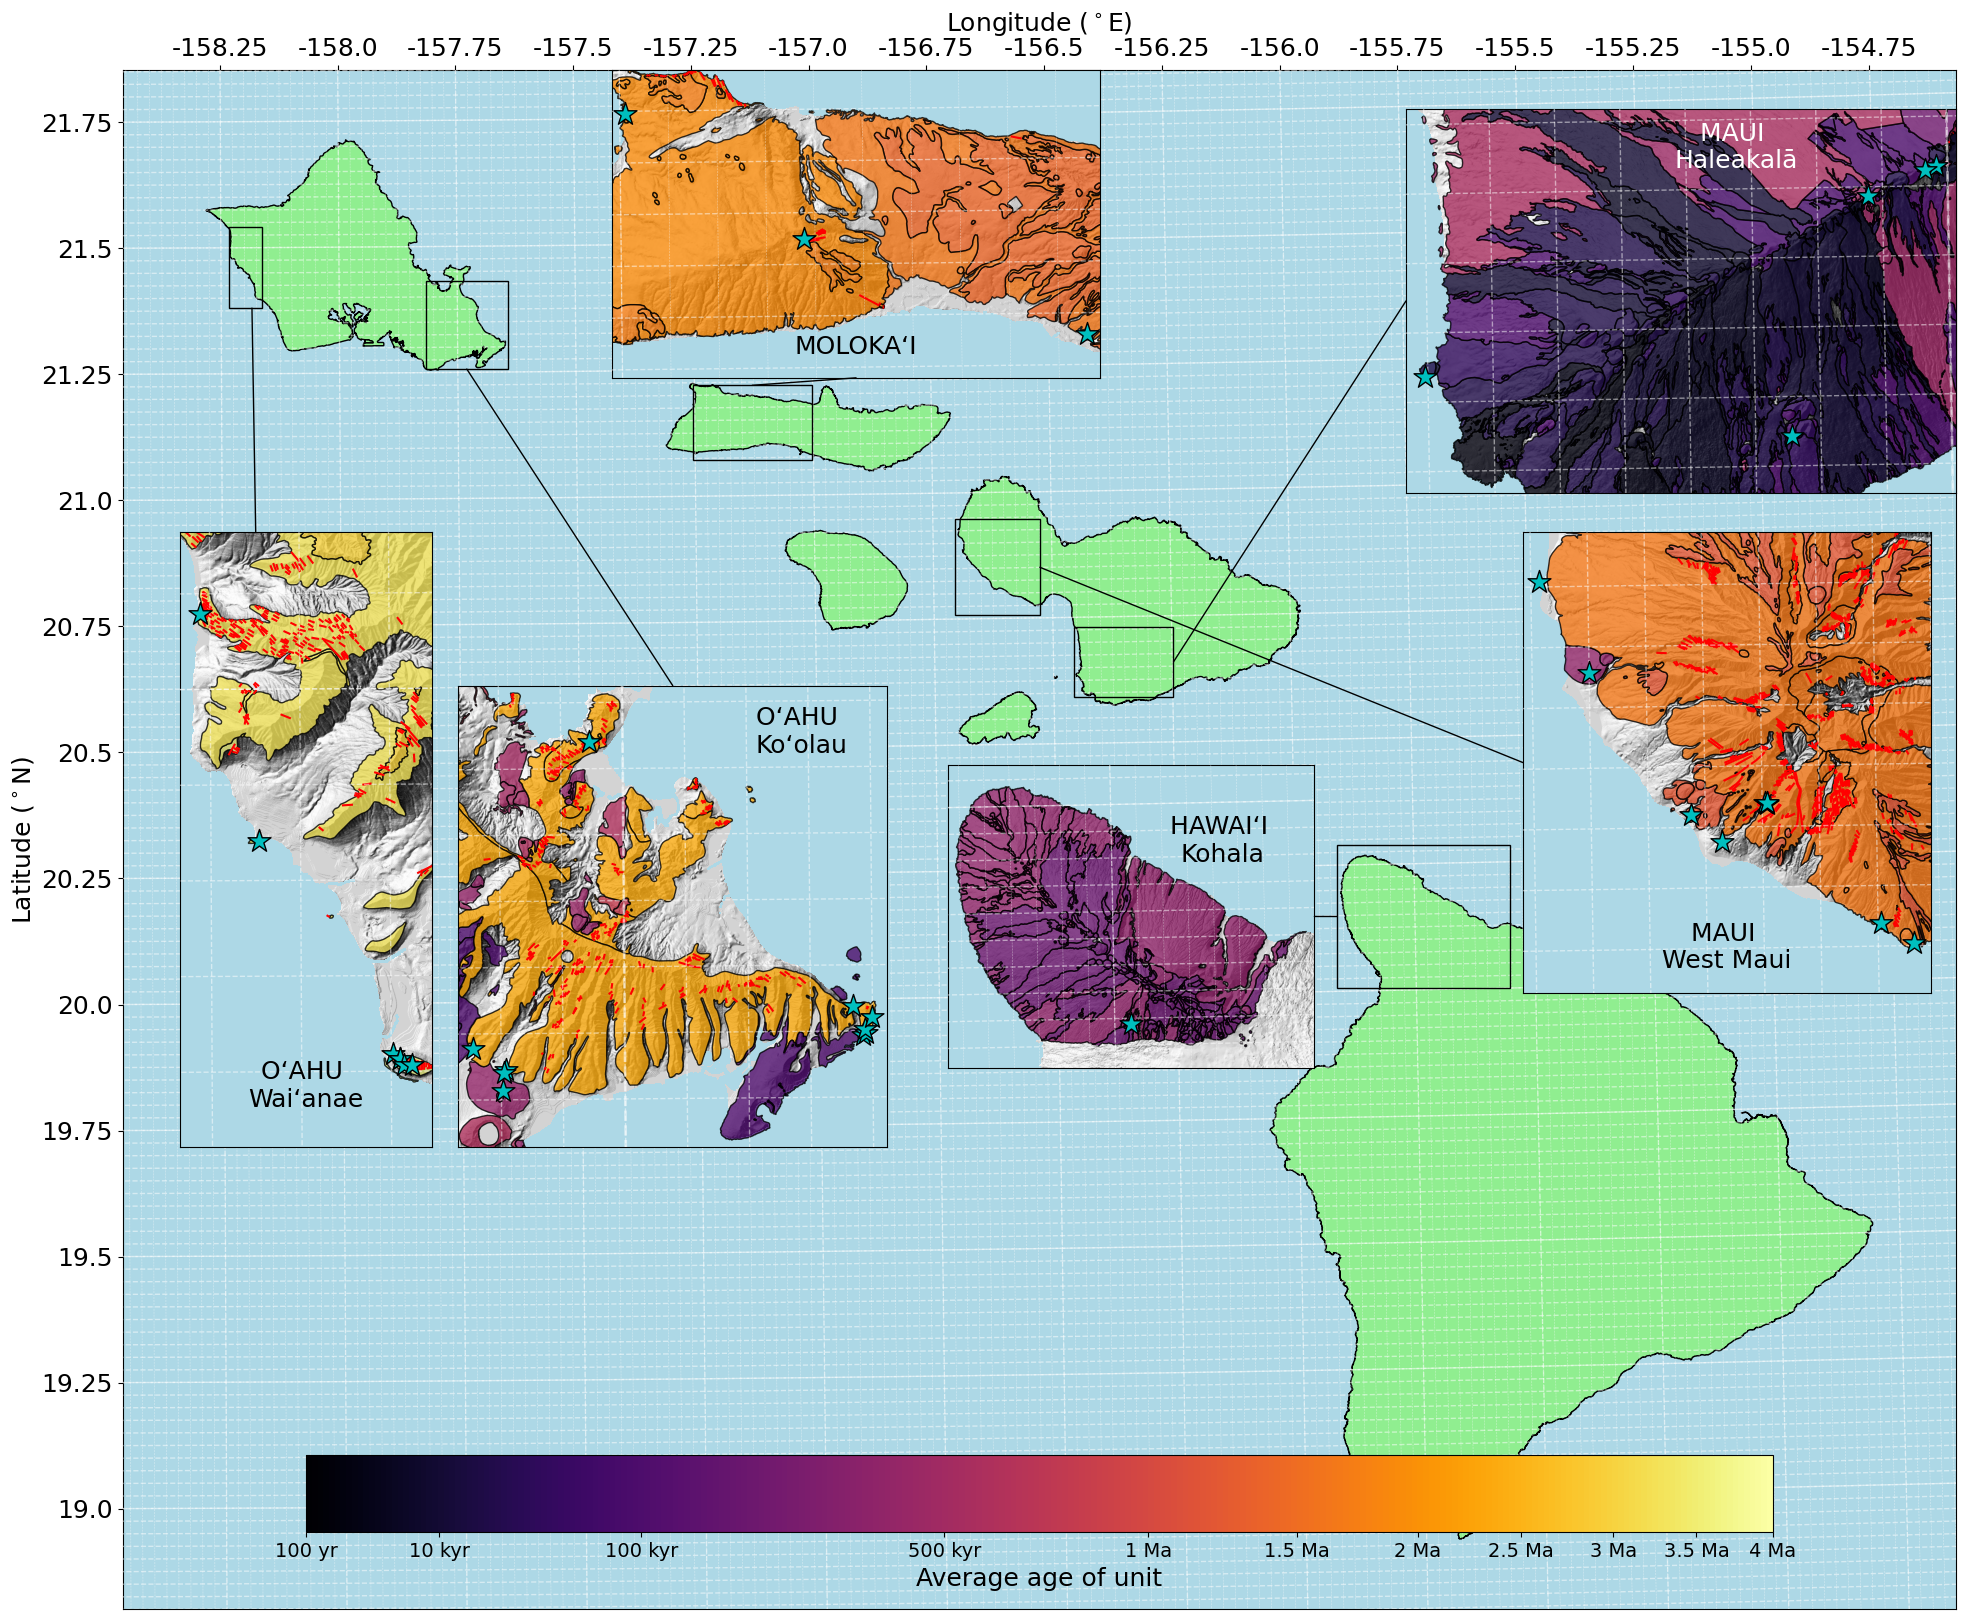

In [7]:
###Plot the main map with Hawaii's Coastline
fig,largemap=plt.subplots(figsize=(20,20))

#Make oceans blue
largemap.set_facecolor('lightblue')
largemap.add_artist(largemap.patch)
largemap.patch.set_zorder(-1)

#get x and y limits of map.
xlim=largemap.get_xlim()
ylim=largemap.get_ylim()

#Plot Coastline of Hawaiian Islands
hawaii[~hawaii.isle.isin(['Niihau','Kauai'])].plot(ax=largemap,color='lightgreen',edgecolor='k')
    

#Plot map for Waianae Volcano
#Set up axes
waia=largemap.inset_axes([0,0.3,0.2,0.4])
#Add map to axes
plot_volcano_map('OA',['waia'],waia,'dems/oahu_warped.nc')
#Draw location of inset axes on main map
plot_patch(waia,largemap,[0.3,1])
#Add title to inset map
waia.annotate('OʻAHU \nWaiʻanae',xy=(0.5,0.1),
              xycoords='axes fraction',
              ha='center',va='center',
              fontweight='light',zorder=10)


#Plot map for Koolau volcano
kool=largemap.inset_axes([0.15,0.3,0.3,0.3])
plot_volcano_map('OA',['kool'],kool,'dems/oahu_warped.nc')
plot_patch(kool,largemap,[0.5,1])
kool.annotate('OʻAHU \nKoʻolau',xy=(0.8,0.9),
              xycoords='axes fraction',
              ha='center',va='center',
              fontweight='light',zorder=10)

kool=largemap.inset_axes([0.15,0.3,0.2,0.2])
plot_volcano_map('OA',['kool'],kool,'dems/oahu_warped.nc')
plot_patch(kool,largemap,[0.5,1])
#kool.annotate('OʻAHU \nKoʻolau',xy=(0.8,0.9),
              #xycoords='axes fraction',
              #ha='center',va='center',
              #fontweight='light',zorder=10)

#Plot map for Kohala Volcano
koha=largemap.inset_axes([0.45,0.35,0.2,0.2])
plot_volcano_map('HW',['koha'],koha,'dems/bigisland_warped.nc',rescale=False)
plot_patch(koha,largemap,[1,0.5])
koha.annotate('HAWAIʻI \nKohala',xy=(0.75,0.75),
              xycoords='axes fraction',
              ha='center',va='center',
              fontweight='light',zorder=10)

#Plot map for West Maui Volcano
wmau=largemap.inset_axes([0.725,0.4,0.3,0.3])
plot_volcano_map('MU',['wmau'],wmau,'dems/maui_warped.nc')
plot_patch(wmau,largemap,[0,0.5])
wmau.annotate('MAUI \nWest Maui',xy=(0.5,0.1),
              xycoords='axes fraction',
              ha='center',va='center',
              fontweight='light',zorder=10)

#Plot map for Haleakala Volcano
hale=largemap.inset_axes([0.7,0.7,0.3,0.3])
plot_volcano_map('MU',['hale'],hale,'dems/maui_warped.nc')
plot_patch(hale,largemap,[0,0.5])
hale.annotate('MAUI \nHaleakalā',xy=(0.6,0.9),
              xycoords='axes fraction',
              ha='center',va='center',
              fontweight='light',color='w')

#Plot map for west and east molokai
mol=largemap.inset_axes([0.15,0.8,0.5,0.2])
plot_volcano_map('ML',['wmol','emol'],mol,'dems/molokai_warped.nc')
plot_patch(mol,largemap,[0.5,0])
mol.annotate('MOLOKAʻI',xy=(0.5,0.1),
             xycoords='axes fraction',
             ha='center',va='center',
             fontweight='light',zorder=10)


#Set up color scale
norm=PowerNorm(gamma=0.4,vmin=1e-4,vmax=4) 
mappable=ScalarMappable(norm,cmap='inferno') 

#Make tick labels for colorbar
ticklabels=['100 yr','10 kyr','100 kyr','500 kyr','1 Ma',
            '1.5 Ma', '2 Ma','2.5 Ma', '3 Ma','3.5 Ma','4 Ma']
cax = largemap.inset_axes([0.1,0.05,0.8,0.05]) #Axis for colorbar

#Plot colorbar
cbar=fig.colorbar(mappable,cax=cax,label='Age',orientation='horizontal')
cbar.set_ticks([1e-4,1e-2,1e-1,5e-1,1,1.5,2,2.5,3,3.5,4])
cbar.set_ticklabels(ticklabels) #Set tick labels
cbar.set_label(label='Average age of unit', fontsize=18)
cbar.ax.tick_params(labelsize=14)


#Plot grids for main map
plot_grids(largemap,4,1,3,set_ticks=True) #Major grids
plot_grids(largemap,40,0.4,3) #Minor grids

#Plot major and minor grids for each inset axis
for ax in [waia,kool,wmau,hale]:
    plot_grids(ax,4,2,3,set_ticks=False)
    plot_grids(ax,40,1,3)

#Kohala and Molokai look better with thinner lines
plot_grids(koha,4,1,3,set_ticks=False)
plot_grids(koha,40,0.4,3)
plot_grids(mol,4,1,3,set_ticks=False)
plot_grids(mol,40,0.4,3)


plt.xlabel('Longitude ($^\circ$E)')
plt.ylabel('Latitude ($^\circ$N)')
largemap.xaxis.set_label_position('top')
#Save Figure
plt.tight_layout()
plt.savefig('Figures/Volcano_Maps_Extra.pdf',bbox_inches='tight')